- Добавить другие признаки помимо лагов 
- Добавить валидацию не холдаут, а роллинг (или бэктестинг)
- Разные способы ансамблирования
- Разные датасеты под разные задачи

# Домашнее задание №2

### ИИ 2025-2026. Анализ временных рядов

**Выдано:** 28.01.2026

- **Мягкий дедлайн:** 11.02.2026 23:59
- **Жесткий дедлайн:** 18.02.2026 23:59

За каждый день просрочки после мягкого дедлайна снимается 1 балл.

```
Обратите внимание, что если у ассистента возникают подозрения по честному выполнению заданий (плагиат, чрезмерное использование LLM и/или использование LLM без указания промпта), то он может поставить вам устное собеседование по проделанной работе, по итогам которого он вправе обнулить вам работу.
```

Во второй домашней работе будем работать с ML моделями для прогнозирования временных рядов и рассмотрим несколько дополнительных сюжетов, которые не были затронуты на занятиях, но которые тесно с ними связаны.

В этот раз будем работать не в рамках одного ноутбука, а с использованием нескольких скриптов, которые находятся в папке `modules`. Это сделано для того, чтобы приблизить выполнение домашнего задания к реальным условиям работы с ML проектами.

В начале вас может напугать то, что теперь нужно работать с несколькими файлами, в которых еще и много кода но на самом деле большую часть кода мы уже разобрали на занятиях, и вам останется только реализовать несколько небольших функций и классов. Зато это позволит вам научиться работать с проектами, которые состоят из нескольких файлов, а также читать и понимать чужой код.

In [1]:
import random
from typing import Sequence, Tuple, Union

# Будем использовать CatBoost в качестве базовой модели
import catboost as cb
import numpy as np
import pandas as pd

# Рисование графиков
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler

# Быстрый прогон бейзлайн моделей
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, AutoTheta, Naive, SeasonalNaive
from statsmodels.tsa.stattools import acf


In [2]:
# |pip install catboost statsforecast plotly pandas numpy matplotlib scikit-learn statsmodels

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)


seed_everything()

На седьмом занятии мы рассмотрели с вами такую тему как стратегии прогнозирования на несколько шагов вперед. Мы рассмотрели несколько стратегий, но реализовали только Recursive, из которой вытекает Recursive-MIMO и MIMO. 

Давайте теперь реализуем еще одну стратегию — Direct (а заодно сразу получим и Direct-MIMO).  

### Задание 1: Загрузка данных и определение условий задачи прогнозирования (1 балл)

В этом задании возьмем датасет [METR-LA](https://drive.google.com/drive/folders/10FOTa6HXPqX8Pf5WRoRwcFnW9BrNZEIX), который содержит временные ряды скорости движения с 207 дорожных сенсоров, расположенных на автомагистралях округа Лос-Анджелес. Измерения агрегированы с шагом 5 минут и покрывают наблюдения с 2012-03-01 по 2012-06-28. 

Мы заранее сделали ресемплирование до 60 минут, а так же оставили только последние 10 недель данных (чтобы обучение не занимало слишком много времени) и 10 случайных рядов. Более того, мы привели данные к более удобному виду, где датафрейм представлен в виде трех столбцов: `timestamp`, `sensor_id`, `value`. 

__Подгрузите данные из файла `metr-la_preprocessed.csv` (0 баллов).__

In [3]:
from google.colab import files
uploaded = files.upload()


ModuleNotFoundError: No module named 'google'

In [4]:
df = pd.read_csv('metr-la_preprocessed.csv')

# Возьмем небольшой сэмпл для ускорения вычислений
random_ids = random.sample(df["sensor_id"].unique().tolist(), 10)
df = df[df["sensor_id"].isin(random_ids)].reset_index(drop=True)

__Выведите типы данных в датасете. Проверьте, что они корректные: даты должны быть в формате datetime, а значения — в float. id оставьте в int. Если это не так, то исправьте их (0.1 балла).__

In [5]:
df.head(2)

,timestamp,sensor_id,value
0,2012-04-18 23:00:00,773062,64.997685
1,2012-04-19 00:00:00,773062,65.455357


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16810 entries, 0 to 16809
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  16810 non-null  object 
 1   sensor_id  16810 non-null  int64  
 2   value      16810 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 394.1+ KB


In [7]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16810 entries, 0 to 16809
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  16810 non-null  datetime64[ns]
 1   sensor_id  16810 non-null  int64         
 2   value      16810 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 394.1 KB


__Проверьте, есть ли в данных пропуски. Если они есть, то заполните их предыдущими значениями. Если пропусков нет, то просто выведите сообщение об этом (0.1 балла).__

In [8]:
missing = df.isna().sum()
print(missing)

timestamp    0
sensor_id    0
value        0
dtype: int64


__Постройте линейные графики десяти случайных рядов из датасета. По оси X отложите время, по оси Y — значения временного ряда. Ответьте на вопросы ниже. (0.5 баллов)__

In [9]:
fig = go.Figure()

for sensor_id in df["sensor_id"].unique():
    tmp = df[df["sensor_id"] == sensor_id]
    fig.add_trace(
        go.Scatter(
            x=tmp["timestamp"],
            y=tmp["value"],
            mode="lines",
            name=f"sensor {sensor_id}"
        )
    )

fig.update_layout(
    title="10 random",
    xaxis_title="Time",
    yaxis_title="Value",
    template="plotly_white",
    width=1000,
    height=500
)

fig.show()

__Ответьте на следующие вопросы:__
- Какова частотность (frequency) данных?
- Являются ли временные ряды выровненными (начинаются и заканчиваются в одно и то же время)?
- Стационарны ли временной ряд? Если нет, то какие признаки нестационарности вы можете выделить? Если в данных есть сезонность, по каков ее период?
- Похожи ли между собой разные временные ряды? Какие закономерности вы можете выделить?

- частотность = 1 часу
- да, ряды выровнены
- нет, они не стационарны. Можно заметить сезонность, НЕпостоянные среднее и дисперсия. Сезонность с периодом 24 часа
- да, ряды похожи. Похожие пики, периодические провалы к нулю, высокая дисперсия/сильные колебания

Далее проверяю на всякий случай с помощью кода - так как на график енельзя сказать со 100% уверенностью

In [10]:
df = df.sort_values(["sensor_id", "timestamp"])

freqs = {}

for sid, g in df.groupby("sensor_id"):
    deltas = g["timestamp"].diff().dropna()
    main_freq = deltas.value_counts().idxmax()
    freqs[sid] = main_freq

freqs_series = pd.Series(freqs, name="frequency")
print(freqs_series)


717459   0 days 01:00:00
717462   0 days 01:00:00
717490   0 days 01:00:00
717804   0 days 01:00:00
764949   0 days 01:00:00
767573   0 days 01:00:00
769926   0 days 01:00:00
769941   0 days 01:00:00
773062   0 days 01:00:00
774067   0 days 01:00:00
Name: frequency, dtype: timedelta64[ns]


In [11]:
ranges = (
    df.groupby("sensor_id")["timestamp"]
    .agg(["min", "max", "count"])
)

print(ranges)
print("\nSame start:", ranges["min"].nunique() == 1)
print("Same end:", ranges["max"].nunique() == 1)
print("Same length:", ranges["count"].nunique() == 1)

                          min                 max  count
sensor_id                                               
717459    2012-04-18 23:00:00 2012-06-27 23:00:00   1681
717462    2012-04-18 23:00:00 2012-06-27 23:00:00   1681
717490    2012-04-18 23:00:00 2012-06-27 23:00:00   1681
717804    2012-04-18 23:00:00 2012-06-27 23:00:00   1681
764949    2012-04-18 23:00:00 2012-06-27 23:00:00   1681
767573    2012-04-18 23:00:00 2012-06-27 23:00:00   1681
769926    2012-04-18 23:00:00 2012-06-27 23:00:00   1681
769941    2012-04-18 23:00:00 2012-06-27 23:00:00   1681
773062    2012-04-18 23:00:00 2012-06-27 23:00:00   1681
774067    2012-04-18 23:00:00 2012-06-27 23:00:00   1681

Same start: True
Same end: True
Same length: True


__Для подтверждения периода сезонности постройте графики автокорреляционной функции (ACF) для трех рядов из нарисованных выше.__

__Замените нули временного ряда на локальное среднее в окне 5, чтобы избежать ложных пиков (0.3 балла).__ `Но не оставляйте их для следующих заданий (верните эти значения на 0).`

In [12]:
df_tmp = df.copy()

mask = df_tmp["value"] == 0
df_tmp.loc[mask, "value"] = (
    df_tmp.groupby("sensor_id")["value"]
    .transform(lambda x: x.rolling(5, min_periods=1, center=True).mean())
)

sensor_ids = df_tmp["sensor_id"].unique()[:3]


fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=[f"ACF for sensor {sid}" for sid in sensor_ids]
)

for i, sensor_id in enumerate(sensor_ids):
    series = df_tmp[df_tmp["sensor_id"] == sensor_id]["value"]
    acf_vals = acf(series, nlags=100, fft=True)
    lags = list(range(len(acf_vals)))

    fig.add_trace(
        go.Bar(
            x=lags,
            y=acf_vals,
            name=f"Sensor {sensor_id}",
            showlegend=False
        ),
        row=i+1, col=1
    )


fig.update_layout(
    height=800,
    width=1000,
    title_text="Autocorrelation Function (ACF)",
    template="plotly_white"
)


fig.update_yaxes(title_text="ACF", showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_xaxes(title_text="Lag", row=3, col=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.show()

>Можно заметить пики на лагах 24, 48, 72 - это говорит от сезонности с периодом = 1 день = 24 часа

Зафиксируем следующие параметры задачи прогнозирования:
- История (длина входного окна): 24 часа (24 точки при частоте 1 час)
- Горизонт прогнозирования (длина выходного окна): 12 часов (12 точек при частоте 1 час)
- Валидация: expanding (с расширяющимся окном обучения), шаг 1 неделя, начиная с 6 недель обучения. На валидационный набор отводится так же 1 неделя. Здесь валидационный набор — это те данные, которые используются для подбора гиперпараметров модели (в нашем случае early stopping).

In [13]:
HISTORY = 24
HORIZON = 12
START_TRAIN_SIZE = 6 * 7 * 24  # 6 недель
STEP_SIZE = 7 * 24  # 1 неделя

SEASON_LENGTH = 24  # Суточная сезонность
FREQ = "h"  # Частота временного ряда, нужна для StatsForecast

### Задание 2: Реализация валидации с расширяющимся окном обучения и построение бейзлайнов при помощи statsforecast (1 балл)

__Дополните функцию валидации с расширяющимся окном обучения, которая находится в `modules/validation.py`.__

Обратите внимание, что валидационный датасет должен включать в себя `history` точек из конца трейна, помимо собственных 12 точек валидации. Аналогично, тестовый датасет должен включать в себя `history` точек из конца трейна + валидации, помимо собственных 12 точек теста.

Класс StatsforecastModel в `modules/models.py` написан за вас.

Давайте проверим, что всё сделано верно. 

In [14]:
from modules.validation import expanding_window_validation
from modules.models import StatsforecastModel

from statsforecast.models import AutoETS, AutoTheta, Naive, SeasonalNaive

In [15]:
all_results = {}

for model, model_name in [
    (StatsforecastModel(Naive(), FREQ, HORIZON), "Naive"),
    (StatsforecastModel(SeasonalNaive(season_length=SEASON_LENGTH), FREQ, HORIZON), "SeasonalNaive"),
    (StatsforecastModel(AutoETS(season_length=SEASON_LENGTH), FREQ, HORIZON), "AutoETS"),
    (StatsforecastModel(AutoTheta(season_length=SEASON_LENGTH), FREQ, HORIZON), "AutoTheta"),
]:
    print(f"Evaluating model: {model_name}")
    results_df = expanding_window_validation(
        data=df,
        model=model,
        horizon=HORIZON,
        history=HISTORY,
        start_train_size=START_TRAIN_SIZE,
        step_size=STEP_SIZE,
        id_col="sensor_id",
        timestamp_col="timestamp",
        value_col="value",
    )

    all_results[model_name] = results_df

Evaluating model: Naive
Evaluating model: SeasonalNaive
Evaluating model: AutoETS
Evaluating model: AutoTheta


Для того, чтобы проверить корректность реализации, проверьте получившиеся у вас графики с авторскими. Функцию для отрисовки графиков мы берем на себя :)

In [16]:
all_results_df = (
    pd.concat(all_results.values(), keys=all_results.keys(), names=["model", "row_id"])
    .reset_index()
    .drop(columns=["row_id"])
)
all_results_df

,model,sensor_id,fold,timestamp,true_value,predicted_value
0,Naive,717459,0,2012-05-31 11:00:00,63.181713,62.630787
1,Naive,717459,0,2012-05-31 12:00:00,46.191567,62.630787
2,Naive,717459,0,2012-05-31 13:00:00,16.606481,62.630787
3,Naive,717459,0,2012-05-31 14:00:00,57.315972,62.630787
4,Naive,717459,0,2012-05-31 15:00:00,54.298611,62.630787
...,...,...,...,...,...,...
1915,AutoTheta,774067,3,2012-06-21 18:00:00,26.004464,57.563088
1916,AutoTheta,774067,3,2012-06-21 19:00:00,67.834491,68.005625
1917,AutoTheta,774067,3,2012-06-21 20:00:00,65.780258,71.690293
1918,AutoTheta,774067,3,2012-06-21 21:00:00,64.427083,69.276292


In [17]:
def plot_results_expanding_cv(
    df: pd.DataFrame,
    forecast_df: pd.DataFrame,
    id_column: str = "sensor_id",
    time_column: str = "timestamp",
    forecast_column: str = "predicted_value",
    target_column_df: str = "value",
    target_column_forecast_df: str = "true_value",
    fold_column_forecast_df: str = "fold",
    model_column_forecast_df: str = "model",
    num_samples_to_plot: int = 3,
    seed: int = 42,
):
    """Визуализирует expanding window CV.
    Args:
        df: Датафрейм с реальными значениями.
        forecast_df: Датафрейм с прогнозами и информацией о фолдах.
        id_column: Название колонки с идентификатором временного ряда.
        time_column: Название колонки с временной меткой.
        forecast_column: Название колонки с прогнозами.
        target_column_df: Название колонки с реальными значениями в df.
        target_column_forecast_df: Название колонки с реальными значениями в forecast_df.
        fold_column_forecast_df: Название колонки с фолдами в forecast_df.
        model_column_forecast_df: Название колонки с именами моделей в forecast_df.
        num_samples_to_plot: Количество случайных рядов для визуализации.
        seed: random seed для воспроизводимости.

    """
    colors = {
        "history_true": "grey",
        "forecast_true": "blue",
        "forecast_models": px.colors.qualitative.Plotly
    }

    random.seed(seed)
    sampled_ids = random.sample(
        forecast_df[id_column].dropna().unique().tolist(), num_samples_to_plot
    )

    num_folds = forecast_df[fold_column_forecast_df].nunique()
    for series_id in sampled_ids:
        current_df = df[df[id_column] == series_id]
        current_forecast_df = forecast_df[forecast_df[id_column] == series_id]

        fig = make_subplots(
            rows=num_folds,
            cols=1,
            shared_xaxes=True,
            vertical_spacing=0.12,
            subplot_titles=[f"fold={f}" for f in range(num_folds)],
        )

        for fold_idx in range(num_folds):
            current_fold_forecast_df = current_forecast_df[
                current_forecast_df[fold_column_forecast_df] == fold_idx
            ]
            test_start_timestamp = current_fold_forecast_df[time_column].min()

            history = current_df[current_df[time_column] < test_start_timestamp]

            fig.add_trace(
                go.Scatter(
                    x=history[time_column],
                    y=history[target_column_df],
                    mode="lines",
                    name="History (train+val)",
                    legendgroup="history",
                    line=dict(color=colors["history_true"]),
                    showlegend=(fold_idx == 0),
                ),
                row=fold_idx + 1,
                col=1,
            )
            for i, model_name in enumerate(sorted(
                current_fold_forecast_df[model_column_forecast_df].dropna().unique().tolist()
            )):
                mdf = current_fold_forecast_df[
                    current_fold_forecast_df[model_column_forecast_df] == model_name
                ]
                if i == 0:
                    fig.add_trace(
                        go.Scatter(
                            x=mdf[time_column],
                            y=mdf[target_column_forecast_df],
                            mode="lines",
                            name="True (test)",
                            legendgroup="true_test",
                            line=dict(color=colors["forecast_true"]),
                            showlegend=(fold_idx == 0),
                        ),
                        row=fold_idx + 1,
                        col=1,
                    )
                fig.add_trace(
                    go.Scatter(
                        x=mdf[time_column],
                        y=mdf[forecast_column],
                        mode="lines",
                        line=dict(dash="dash", color=colors["forecast_models"][i % len(colors["forecast_models"])]),
                        name=str(model_name),
                        legendgroup=str(model_name),
                        showlegend=(fold_idx == 0),
                    ),
                    row=fold_idx + 1,
                    col=1,
                )
        fig.update_layout(
            title=f"Expanding CV: sensor_id={series_id}",
        )
        fig.show()

In [18]:
plot_results_expanding_cv(df, all_results_df, num_samples_to_plot=1)

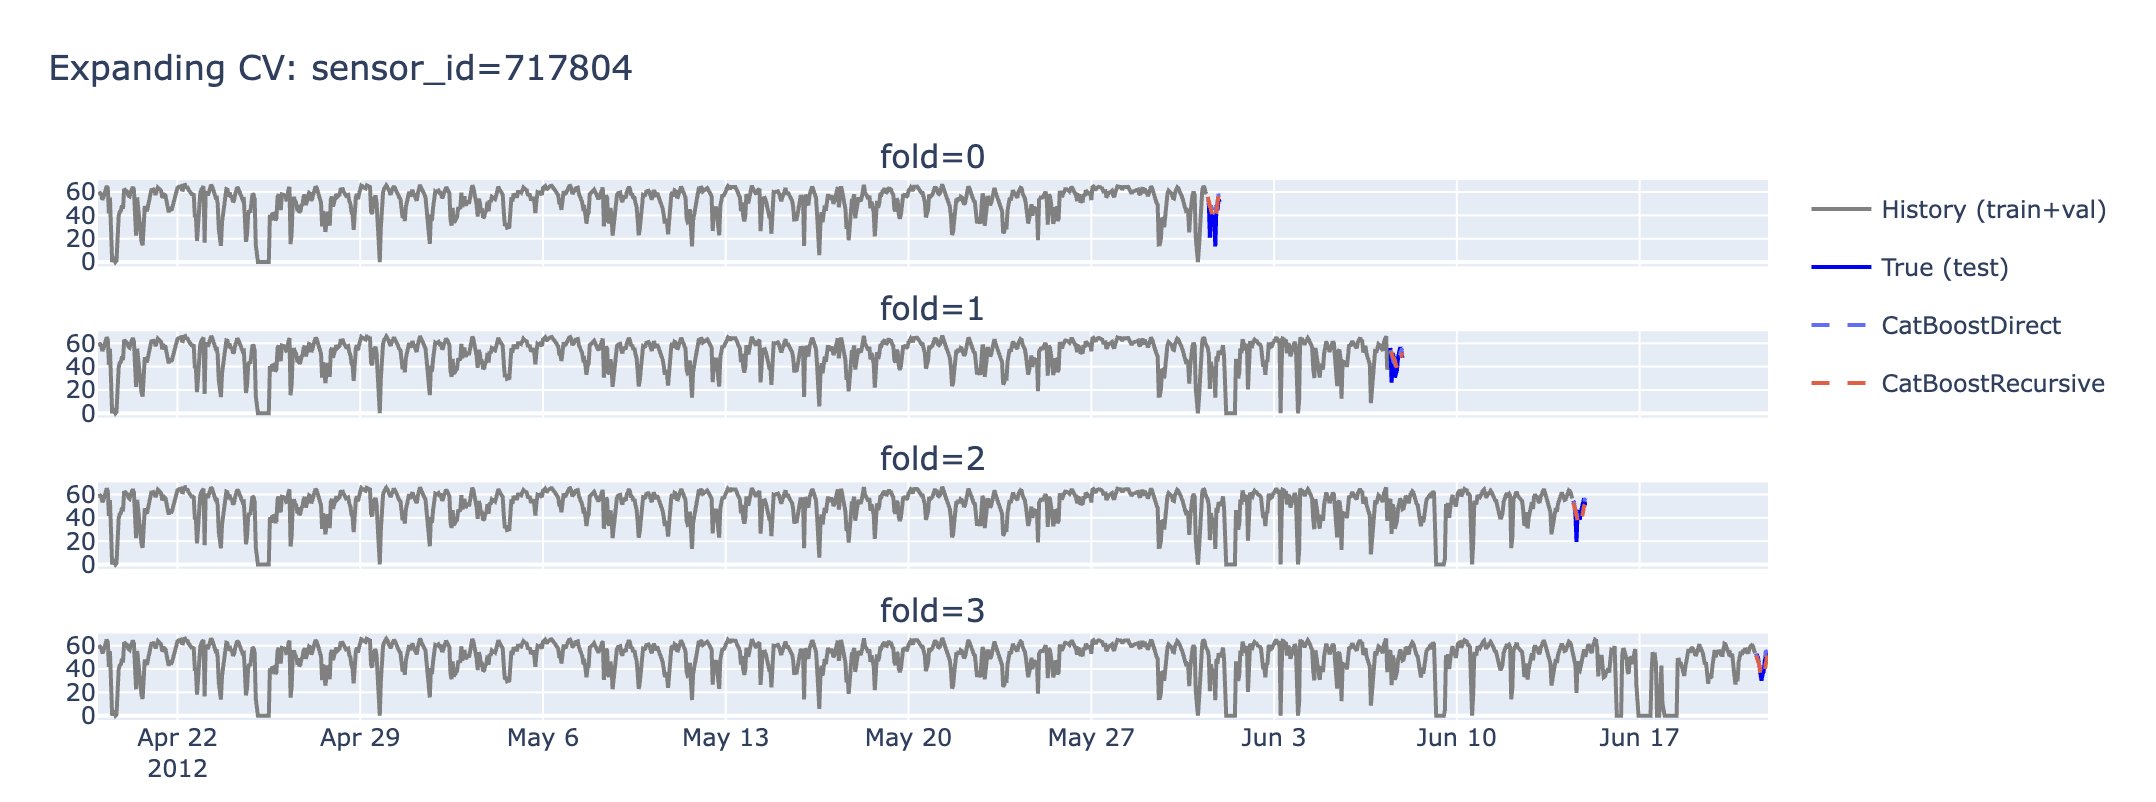

### Задание 3: Реализация метрик (0.5 балла)

Давайте будем использовать в качестве метрик ту, которую мы еще не брали ранее и которая была рекомендована в курсе [Christoph Bergmeir](https://www.youtube.com/watch?v=hrfEGmZjips) как еще одна замена классической метрики MAPE.

WAPE (Weighted Absolute Percentage Error) рассчитывается по формуле:

$$WAPE = \frac{\sum_{t=T+1}^{T+H} |y_t - \hat{y}_t|}{\sum_{t=T+1}^{T+H} |y_t|}$$

где:
- $H$ — горизонт прогнозирования
- $T$ — длина исторических данных
- $y_t$ — истинные значения временного ряда на горизонте прогнозирования
- $\hat{y}_t$ — предсказанные значения временного ряда на горизонте прогнозирования

От MAPE отличается тем, что суммы берутся вне дроби, что позволяет избежать деления на ноль и на малые значения. Можно сказать, что мы взвешиваем общую абсолютную ошибку по абсолютным значениям временного ряда (сколько процентов от общего объема мы ошиблись). 

__Реализуйте расчет этих метрик в функции `calculate_metrics`.__

In [19]:
def calculate_wape(
    group: pd.DataFrame, pred_column: str = "predicted_value", true_column: str = "true_value"
) -> pd.Series:
    """Вычисляет метрику WAPE.

    Args:
        group: Датафрейм с прогнозами и реальными значениями.
        pred_column: Название колонки с прогнозами.
        true_column: Название колонки с реальными значениями.

    Returns:
        pd.Series с рассчитанной метрикой WAPE.

    """
    wape = np.sum(np.abs(group[true_column] - group[pred_column])) / np.sum(np.abs(group[true_column]))
    return pd.Series({"WAPE": wape})

Если всё сделано правильно, то следующая ячейка запуститься без ошибок.

In [20]:
metrics_df = (
    all_results_df
    .groupby(["model", "fold"], as_index=False)
    .apply(calculate_wape, include_groups=False)
    .reset_index(drop=True)
)

print("WAPE по моделям и фолдам:")
display(metrics_df)

print("Среднее и стандартное отклонение WAPE по моделям:")
display(metrics_df.groupby("model").agg({"WAPE": ["mean", "std"]}))

WAPE по моделям и фолдам:


,model,fold,WAPE
0,AutoETS,0,0.222507
1,AutoETS,1,0.226619
2,AutoETS,2,0.202059
3,AutoETS,3,0.211447
4,AutoTheta,0,0.165837
5,AutoTheta,1,0.181772
6,AutoTheta,2,0.160977
7,AutoTheta,3,0.171151
8,Naive,0,0.222236
9,Naive,1,0.205988


Среднее и стандартное отклонение WAPE по моделям:


WAPE          
                   mean       std
model                            
AutoETS        0.215658  0.011102
AutoTheta      0.169934  0.008919
Naive          0.208883  0.009201
SeasonalNaive  0.101748  0.006822

### Задание 4: Реализация Direct и Direct-MIMO (4.5 балла)

__Реализуйте модель CatBoostDirect в файле `modules/models.py`__ аналогично тому, как мы реализовали стратегию Recursive на семинаре. Для примера CatBoostRecursive модель уже приведена в формате класса.

Обратите внимание, что все нужные функции для работы с индексами находятся в файле `modules/index_slicing.py`.

Если в случае с рекурсивной стратегией в случае `model_horizon=1` мы обучали одну модель на один шаг вперед, то в случае с Direct стратегией нам нужно обучать по одной модели на каждый шаг из горизонта прогнозирования. То есть в аттрибутах класса CatBoostDirect self.models должно быть $H$ моделей CatBoost, где $H$ — горизонт прогнозирования.

__Вам необходимо понять, как изменить код рекурсивной стратегии так, чтобы реализовать Direct стратегию.__

Если все сделано правильно, то следующие ячейки должны запуститься без ошибок.

In [21]:
from modules.models import CatBoostRecursive, CatBoostDirect

In [22]:
recursive_results = expanding_window_validation(
    data=df,
    model=CatBoostRecursive(
        model_horizon=1,
        history=HISTORY,
        horizon=HORIZON,
        freq=FREQ,
    ),
    horizon=HORIZON,
    history=HISTORY,
    start_train_size=START_TRAIN_SIZE,
    step_size=STEP_SIZE,
    id_col="sensor_id",
    timestamp_col="timestamp",
    value_col="value",
)

0:	learn: 14.0289901	test: 13.9783269	best: 13.9783269 (0)	total: 66ms	remaining: 1m 38s
100:	learn: 7.8386855	test: 8.6300957	best: 8.6300957 (100)	total: 401ms	remaining: 5.56s
200:	learn: 7.2366316	test: 8.1237292	best: 8.1237292 (200)	total: 726ms	remaining: 4.69s
300:	learn: 6.9058843	test: 7.8834234	best: 7.8809650 (298)	total: 1.06s	remaining: 4.21s
400:	learn: 6.6233747	test: 7.7360146	best: 7.7312174 (396)	total: 1.47s	remaining: 4.04s
500:	learn: 6.4044430	test: 7.6250002	best: 7.6214769 (495)	total: 1.87s	remaining: 3.73s
600:	learn: 6.2110894	test: 7.5870611	best: 7.5868959 (599)	total: 2.29s	remaining: 3.42s
700:	learn: 6.0378373	test: 7.5003330	best: 7.5003330 (700)	total: 2.68s	remaining: 3.05s
800:	learn: 5.8738969	test: 7.4346137	best: 7.4300030 (788)	total: 3.03s	remaining: 2.64s
900:	learn: 5.7180022	test: 7.4237426	best: 7.4127482 (865)	total: 3.38s	remaining: 2.25s
1000:	learn: 5.5752976	test: 7.3803354	best: 7.3765937 (970)	total: 3.73s	remaining: 1.86s
1100:	lear

In [23]:
direct_results = expanding_window_validation(
    data=df,
    model=CatBoostDirect(
        model_horizon=1,
        history=HISTORY,
        horizon=HORIZON,
        freq=FREQ,
    ),
    horizon=HORIZON,
    history=HISTORY,
    start_train_size=START_TRAIN_SIZE,
    step_size=STEP_SIZE,
    id_col="sensor_id",
    timestamp_col="timestamp",
    value_col="value",
)

Обучение модели для шага 1 из 12
Обучение модели для шага 2 из 12
Обучение модели для шага 3 из 12
Обучение модели для шага 4 из 12
Обучение модели для шага 5 из 12
Обучение модели для шага 6 из 12
Обучение модели для шага 7 из 12
Обучение модели для шага 8 из 12
Обучение модели для шага 9 из 12
Обучение модели для шага 10 из 12
Обучение модели для шага 11 из 12
Обучение модели для шага 12 из 12
Обучение модели для шага 1 из 12
Обучение модели для шага 2 из 12
Обучение модели для шага 3 из 12
Обучение модели для шага 4 из 12
Обучение модели для шага 5 из 12
Обучение модели для шага 6 из 12
Обучение модели для шага 7 из 12
Обучение модели для шага 8 из 12
Обучение модели для шага 9 из 12
Обучение модели для шага 10 из 12
Обучение модели для шага 11 из 12
Обучение модели для шага 12 из 12
Обучение модели для шага 1 из 12
Обучение модели для шага 2 из 12
Обучение модели для шага 3 из 12
Обучение модели для шага 4 из 12
Обучение модели для шага 5 из 12
Обучение модели для шага 6 из 12
Обуч

In [25]:
ml_results_df = pd.concat(
    [
        recursive_results.assign(model="CatBoostRecursive"),
        direct_results.assign(model="CatBoostDirect"),
    ],
    ignore_index=True,
)
ml_results_df

,sensor_id,fold,timestamp,true_value,predicted_value,model
0,717459,0,2012-05-31 11:00:00,63.181713,63.013776,CatBoostRecursive
1,717459,0,2012-05-31 12:00:00,46.191567,62.779117,CatBoostRecursive
2,717459,0,2012-05-31 13:00:00,16.606481,62.738949,CatBoostRecursive
3,717459,0,2012-05-31 14:00:00,57.315972,60.718758,CatBoostRecursive
4,717459,0,2012-05-31 15:00:00,54.298611,54.625524,CatBoostRecursive
...,...,...,...,...,...,...
955,774067,3,2012-06-21 18:00:00,26.004464,59.615027,CatBoostDirect
956,774067,3,2012-06-21 19:00:00,67.834491,60.311556,CatBoostDirect
957,774067,3,2012-06-21 20:00:00,65.780258,60.065465,CatBoostDirect
958,774067,3,2012-06-21 21:00:00,64.427083,55.818521,CatBoostDirect


In [26]:
recursive_results

,sensor_id,fold,timestamp,true_value,predicted_value
0,717459,0,2012-05-31 11:00:00,63.181713,63.013776
1,717459,0,2012-05-31 12:00:00,46.191567,62.779117
2,717459,0,2012-05-31 13:00:00,16.606481,62.738949
3,717459,0,2012-05-31 14:00:00,57.315972,60.718758
4,717459,0,2012-05-31 15:00:00,54.298611,54.625524
...,...,...,...,...,...
475,774067,3,2012-06-21 18:00:00,26.004464,61.703111
476,774067,3,2012-06-21 19:00:00,67.834491,62.386784
477,774067,3,2012-06-21 20:00:00,65.780258,62.388293
478,774067,3,2012-06-21 21:00:00,64.427083,62.290839


In [27]:
plot_results_expanding_cv(df, ml_results_df, num_samples_to_plot=1)

In [28]:
metrics_df = (
    ml_results_df
    .groupby(["model", "fold"], as_index=False)
    .apply(calculate_wape, include_groups=False)
    .reset_index(drop=True)
)

print("WAPE по моделям и фолдам:")
display(metrics_df)

print("Среднее и стандартное отклонение WAPE по моделям:")
display(metrics_df.groupby("model").agg({"WAPE": ["mean", "std"]}))

WAPE по моделям и фолдам:


,model,fold,WAPE
0,CatBoostDirect,0,0.117085
1,CatBoostDirect,1,0.256493
2,CatBoostDirect,2,0.182454
3,CatBoostDirect,3,0.168540
4,CatBoostRecursive,0,0.105523
5,CatBoostRecursive,1,0.223768
6,CatBoostRecursive,2,0.121732
7,CatBoostRecursive,3,0.139731


Среднее и стандартное отклонение WAPE по моделям:


WAPE          
                       mean       std
model                                
CatBoostDirect     0.181143  0.057566
CatBoostRecursive  0.147688  0.052609

### Задание 5: Сравнение моделей (2 балла)

Возьмите промежуточный вариант стратегий (Direct-MIMO и Recursive-MIMO) с model_horizon = 3. Также возьмите не 10 рядов, а хотя бы 30. Сравните качество получившихся моделей с качеством полных Direct, Recursive и MIMO стратегий (model_horizon = 1). Какой из вариантов показал себя лучше? Почему, на ваш взгляд, так произошло?

In [84]:
df = pd.read_csv('metr-la_preprocessed.csv')
random_ids = random.sample(df["sensor_id"].unique().tolist(), 30)
df = df[df["sensor_id"].isin(random_ids)].reset_index(drop=True)
df["timestamp"] = pd.to_datetime(df["timestamp"])
missing = df.isna().sum()
print(missing)

timestamp    0
sensor_id    0
value        0
dtype: int64


In [88]:
recursive_results_for30_mh1 = expanding_window_validation(
    data=df,
    model=CatBoostRecursive(
        model_horizon=1,
        history=HISTORY,
        horizon=HORIZON,
        freq=FREQ,
    ),
    horizon=HORIZON,
    history=HISTORY,
    start_train_size=START_TRAIN_SIZE,
    step_size=STEP_SIZE,
    id_col="sensor_id",
    timestamp_col="timestamp",
    value_col="value",
)

recursive_results_for30_mh3 = expanding_window_validation(
    data=df,
    model=CatBoostRecursive(
        model_horizon=3,
        history=HISTORY,
        horizon=HORIZON,
        freq=FREQ,
    ),
    horizon=HORIZON,
    history=HISTORY,
    start_train_size=START_TRAIN_SIZE,
    step_size=STEP_SIZE,
    id_col="sensor_id",
    timestamp_col="timestamp",
    value_col="value",
)

mimo_results_for30 = expanding_window_validation(
    data=df,
    model=CatBoostRecursive(
        model_horizon=HORIZON,
        history=HISTORY,
        horizon=HORIZON,
        freq=FREQ,
    ),
    horizon=HORIZON,
    history=HISTORY,
    start_train_size=START_TRAIN_SIZE,
    step_size=STEP_SIZE,
    id_col="sensor_id",
    timestamp_col="timestamp",
    value_col="value",
)

0:	learn: 15.9137270	test: 13.7765299	best: 13.7765299 (0)	total: 14.4ms	remaining: 21.5s
100:	learn: 8.0727075	test: 8.4310092	best: 8.4310092 (100)	total: 1.29s	remaining: 17.9s
200:	learn: 7.2895197	test: 7.7678529	best: 7.7673731 (199)	total: 2.57s	remaining: 16.6s
300:	learn: 6.8907721	test: 7.4273501	best: 7.4273501 (300)	total: 3.75s	remaining: 14.9s
400:	learn: 6.5904068	test: 7.2065147	best: 7.2053979 (397)	total: 5s	remaining: 13.7s
500:	learn: 6.3781246	test: 7.0586246	best: 7.0576165 (498)	total: 6.33s	remaining: 12.6s
600:	learn: 6.1787790	test: 6.9659079	best: 6.9656112 (597)	total: 7.52s	remaining: 11.2s
700:	learn: 5.9925433	test: 6.8510803	best: 6.8510803 (700)	total: 8.71s	remaining: 9.92s
800:	learn: 5.8461636	test: 6.7564245	best: 6.7564245 (800)	total: 10s	remaining: 8.75s
900:	learn: 5.7215426	test: 6.7051732	best: 6.7051594 (899)	total: 11.2s	remaining: 7.45s
1000:	learn: 5.6033230	test: 6.6528188	best: 6.6522076 (997)	total: 12.4s	remaining: 6.17s
1100:	learn: 5

KeyboardInterrupt: 

In [89]:
recursive_results_for30_mh1

,sensor_id,fold,timestamp,true_value,predicted_value
0,767541,0,2012-05-31 11:00:00,64.150463,62.945582
1,767541,0,2012-05-31 12:00:00,59.311673,62.605432
2,767541,0,2012-05-31 13:00:00,64.679398,62.540328
3,767541,0,2012-05-31 14:00:00,65.011574,61.716226
4,767541,0,2012-05-31 15:00:00,64.254630,60.097758
...,...,...,...,...,...
1435,718141,3,2012-06-21 18:00:00,41.165013,52.110818
1436,718141,3,2012-06-21 19:00:00,59.025463,58.209293
1437,718141,3,2012-06-21 20:00:00,60.401455,62.254268
1438,718141,3,2012-06-21 21:00:00,66.802083,63.560879


In [90]:
recursive_results_for30_mh3

,sensor_id,fold,timestamp,true_value,predicted_value
0,767541,0,2012-05-31 11:00:00,64.150463,64.588841
1,767541,0,2012-05-31 12:00:00,59.311673,63.154518
2,767541,0,2012-05-31 13:00:00,64.679398,63.756333
3,767541,0,2012-05-31 14:00:00,65.011574,64.757751
4,767541,0,2012-05-31 15:00:00,64.254630,62.102631
...,...,...,...,...,...
1435,718141,3,2012-06-21 18:00:00,41.165013,60.128131
1436,718141,3,2012-06-21 19:00:00,59.025463,59.095301
1437,718141,3,2012-06-21 20:00:00,60.401455,61.259436
1438,718141,3,2012-06-21 21:00:00,66.802083,62.586871


In [91]:
ml_results_df_all = pd.concat(
    [
        recursive_results_for30_mh1.assign(model="CatBoostRecursiveMH1"),
        recursive_results_for30_mh3.assign(model="CatBoostRecursiveMH3"),
    ],
    ignore_index=True,
)

metrics_df_all = (
    ml_results_df_all
    .groupby(["model", "fold"], as_index=False)
    .apply(calculate_wape, include_groups=False)
    .reset_index(drop=True)
)

print("WAPE по моделям и фолдам:")
display(metrics_df_all)

print("Среднее и стандартное отклонение WAPE по моделям:")
display(metrics_df_all.groupby("model").agg({"WAPE": ["mean", "std"]}))

WAPE по моделям и фолдам:


,model,fold,WAPE
0,CatBoostRecursiveMH1,0,0.152234
1,CatBoostRecursiveMH1,1,0.203893
2,CatBoostRecursiveMH1,2,0.154810
3,CatBoostRecursiveMH1,3,0.145085
4,CatBoostRecursiveMH3,0,0.183538
5,CatBoostRecursiveMH3,1,0.227154
6,CatBoostRecursiveMH3,2,0.204690
7,CatBoostRecursiveMH3,3,0.172096


Среднее и стандартное отклонение WAPE по моделям:


WAPE          
                          mean       std
model                                   
CatBoostRecursiveMH1  0.164005  0.026908
CatBoostRecursiveMH3  0.196870  0.024288

In [ ]:
direct_results_for30_mh1 = expanding_window_validation(
    data=df,
    model=CatBoostDirect(
        model_horizon=1,
        history=HISTORY,
        horizon=HORIZON,
        freq=FREQ,
    ),
    horizon=HORIZON,
    history=HISTORY,
    start_train_size=START_TRAIN_SIZE,
    step_size=STEP_SIZE,
    id_col="sensor_id",
    timestamp_col="timestamp",
    value_col="value",
)

direct_results_for30_mh3 = expanding_window_validation(
    data=df,
    model=CatBoostDirect(
        model_horizon=3,
        history=HISTORY,
        horizon=HORIZON,
        freq=FREQ,
    ),
    horizon=HORIZON,
    history=HISTORY,
    start_train_size=START_TRAIN_SIZE,
    step_size=STEP_SIZE,
    id_col="sensor_id",
    timestamp_col="timestamp",
    value_col="value",
)

### Задание 6: Добавим больше фичей (1 балл)

Добавьте в функции `get_features_df_and_targets` из файла `modules/feature_generation.py` добавьте несколько оконных признаков (например, скользящие средние или std). Проверьте, улучшилось ли качество лучшей модели при добавлении этих признаков.

In [ ]:
# --- Your code here ---

## Бонус (до 3-х баллов):

Попробуйте найти узкие места в коде и оптимизировать его, чтобы обучение и предсказание происходило быстрее. Например, можно попробовать параллелить обучение моделей при помощи многопоточности или многопроцессорности. 

- 3 балла вы получите, если найдете хотя бы 2 способа оптимизации кода и сможете сократить время обучения и Recusive и Direct стратегий до такого значения, чтобы вы смогли получить результаты всех стратегий на всем датасете (207 рядов).
- Меньшее количество баллов будет выставлено в зависимости от того, сколько способов оптимизации вы найдете и насколько сильно сократится время обучения и предсказания.

In [ ]:
# --- Your code here ---